# American Express - Default Prediction

[Соревнование](https://www.kaggle.com/competitions/amex-default-prediction/data)

[Нотбук cdeotte = 0.793](https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793)

[Ноутбук amex-catboost-0-793](https://www.kaggle.com/code/huseyincot/amex-catboost-0-793)

[Нотбук Lama](https://www.kaggle.com/code/alexryzhkov/amex-lightautoml-starter)

In [1]:
import gc
import os
import pickle

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import preprocessing
from tqdm import tqdm
from xgboost import plot_importance

import pickle
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
tqdm.pandas()

/home/kate/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Params

In [3]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

In [4]:
index_column = 'customer_ID'
time_column = 'S_2'
target_column = 'target'

In [5]:
tmp = pd.read_feather('train_data_f32.ftr')

In [6]:
nul_filler = {
    'B_3': 0, 'B_4': 0, 'B_5': 0, 'B_6': 0, 'B_7': 0, 'B_8': 0, 'B_9': 0, 'B_10': 0,
    'B_11': 0, 'B_12': 0, 'B_13': 0, 'B_17': -127, 'B_19': 0, 
    'B_20': 0, 'B_21': 0, 'B_22': 0, 'B_23': 0, 'B_24': 0, 'B_25': 0, 'B_26': 0, 'B_27': 0, 'B_28': 0, 'B_29': -127,
    'B_31': -1, 'B_32': 0, 'B_33': -1, 'B_36': 0, 'B_37': 0, 'B_39': -127, 'B_40': 0, 'B_41': 0,
    'B_42': -127,
    
    'D_39': 0, 'D_41': 0, 'D_42': -127, 'D_43': 0, 'D_44': 0, 'D_49': -127, 'D_50': 0,
    'D_51': 0, 'D_53': -127, 'D_54': 1, 'D_56': -127, 'D_58': 0, 'D_59': 0.5,
    'D_60': 0, 'D_61': 0, 'D_62': 0, 'D_65': 0, 'D_69': 0,
    'D_70': 0, 'D_71': 0, 'D_72': 0, 'D_74': 0, 'D_75': 0, 'D_78': 0, 'D_79': 0, 'D_73': -127, 'D_76': -127, 'D_77': -127,
    'D_80': 0, 'D_81': 0, 'D_83': 0, 'D_84': 0, 'D_86': 0, 'D_89': 0, 'D_82': -127, 'D_87': -127, 'D_88': -127, 
    'D_91': 0, 'D_92': 0, 'D_93': 0, 'D_94': 0, 'D_96': 0,
    'D_102': 0, 'D_103': -1, 'D_104': -1, 'D_107': 0, 'D_109': 0, 'D_105': -127, 'D_106': -127, 'D_108': -127,
    'D_110': -127, 'D_111': -127, 'D_112': 1, 'D_113': 0,
    'D_122': -1, 'D_123': 0, 'D_125': 0, 'D_127': 0, 'D_128': -1, 'D_129': -1,
    'D_130': -1, 'D_131': -1, 'D_133': 0, 'D_139': -1, 'D_132': -127, 'D_134': -127, 'D_135': -127, 'D_136': -127, 
    'D_137': -127, 'D_138': -127,
    'D_140': 0, 'D_141': -1, 'D_143': -1, 'D_144': 0, 'D_145': 0, 'D_142': -127,
    
    'P_4': 0,
    
    'R_1': 0,  'R_2': 0, 'R_3': 0, 'R_4': 0, 'R_5': 0, 'R_6': 0, 'R_7': 0, 'R_8': 0, 'R_9': -127,
    'R_10': 0, 'R_11': 0, 'R_12': 1, 'R_13': 0, 'R_14': 0, 'R_15': 0, 'R_16': 0, 'R_17': 0, 'R_18': 0, 'R_19': 0,
    'R_20': 0, 'R_21': 0, 'R_22': 0, 'R_23': 0, 'R_24': 0, 'R_25': 0, 'R_26': -127, 'R_27': 1, 'R_28': 0,
    
    'S_5': 0, 'S_6': 0, 'S_8': 0, 'S_9': -127,
    'S_12': 0, 'S_16': 0, 'S_17': 0, 'S_18': 0, 'S_19': 0,
    'S_20': 0, 'S_22': 0, 'S_23': 0, 'S_24': 0, 'S_25': 1, 'S_26': 0, 'S_27': 0,
    
    'B_14': tmp['B_14'].median(),
    'B_15': tmp['B_15'].median(),
    'B_16': tmp['B_16'].median(),
    'B_18': tmp['B_18'].median(),
    'B_2': tmp['B_2'].median(),
    'B_1': tmp['B_1'].median(),
    
    'D_46': tmp['D_46'].median(),
    'D_47': tmp['D_47'].median(),
    'D_48': tmp['D_48'].median(),
    'D_45': tmp['D_45'].median(),
    'D_52': tmp['D_52'].median(),
    'D_55': tmp['D_55'].median(),
    'D_115': tmp['D_115'].median(),
    'D_118': tmp['D_118'].median(),
    'D_119': tmp['D_119'].median(),
    'D_121': tmp['D_121'].median(),
    'D_124': tmp['D_124'].median(),
    
    'P_2': tmp['P_2'].median(),
    'P_3': tmp['P_3'].median(),

    'S_3': tmp['S_3'].median(),
    'S_7': tmp['S_7'].median(),
    'S_11': tmp['S_11'].median(),
    'S_13': tmp['S_13'].median(),
    'S_15': tmp['S_15'].median(),
}

In [7]:
del tmp

## Данные для задачи

In [8]:
from scipy import signal

def apply_convolution(sig, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(sig, conv, mode='same') / window
    return filtered

In [9]:
def read_file(path='', usecols=None, nrows=None, skiprows=None, cols=None, scaler=None):
    cols_for_noise_removal = [
        'B_1', 'B_2', 'B_3', 'B_4', 'B_18', 
        'D_39', 'D_41', 'D_42', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_52', 'D_55',
        'D_115', 'D_118', 'D_119', 'D_121', 'D_124',
        'P_2', 'P_3',
        'S_3', 'S_7', 'S_11', 'S_13', 'S_15',
        'R_1'
    ]
    # LOAD DATAFRAME
    if nrows and skiprows: 
        df = pd.read_csv(path, nrows=nrows, skiprows=skiprows, header=None, names=cols)
    elif usecols:
        df = pd.read_csv(path, columns=usecols)
    else: 
        df = pd.read_feather(path)
        df = df.dropna(subset=['B_2'])
        
        scaler = scaler.fit(df[cols_for_noise_removal])
        pickle.dump(scaler, open('scaler.sav', 'wb'))
        
        for col in tqdm(cols_for_noise_removal):
            df[[col]] = df[[col]].apply(lambda srs: apply_convolution(srs, 2))
    
    df[cols_for_noise_removal] = scaler.transform(df[cols_for_noise_removal])
    
    # REDUCE DTYPE FOR CUSTOMER_ID
    df = df.set_index('customer_ID')
    # df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')
    
    # REDUCE DTYPE FOR DATE
    df[time_column] = pd.to_datetime(df[time_column])
    
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    df = df.sort_values(['customer_ID','S_2'])
    # df = df.reset_index(drop=True)
    
    # CREATE OVERALL ROW MISS VALUE
    # features = [x for x in df.columns.values if x not in [index_column, target_column]]
    # df['n_missing'] = df[features].isna().sum(axis=1)
    
    # FILL NAN
    # features_num = [x for x in df._get_numeric_data().columns.values if x not in ['customer_ID', 'target']]
    # df[features_num] = df[features_num].fillna(NAN_VALUE) 
    for col in nul_filler.keys():
        df[col] = df[col].fillna(nul_filler[col])
    
    # Dataset info
    print('Shape of data:', df.shape)
    print('Len of columns:', len(df.columns))
    
    # Use garbage collector
    _ = gc.collect()
    
    return df

In [10]:
# Shape of data: (5531451, 190)
print('Reading train data...')
scaler = StandardScaler()
train_df = read_file(path='train_data_f32.ftr', scaler=scaler)

Reading train data...


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Shape of data: (5529435, 190)
Len of columns: 190


In [11]:
train_df = train_df.sample(frac=0.01)
train_df.shape

(55294, 190)

In [12]:
train_df.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
13556845364555110066,2017-08-30,0.266894,0.155552,1.868095,-1.481090,-0.328617,0.163908,-0.271759,1.481126,-127.0,...,-127.0,-127.0,0.003229,0.009943,0.007743,-127.0,0.002384,0.005791,0.004957,0
15076569329621789969,2017-12-16,0.152331,-0.543989,-0.552930,0.476653,-0.323603,-0.288278,-0.261728,-0.515026,-127.0,...,-127.0,-127.0,0.007109,0.008737,0.002658,-127.0,0.001318,0.006652,0.001155,0
10857032762044505223,2018-01-19,1.202808,-0.553440,-0.558072,0.482375,-0.324165,0.163908,-0.274029,-0.555583,-127.0,...,-127.0,-127.0,0.000783,0.009069,0.008185,-127.0,0.003196,0.001202,0.001815,0
9479854372293242539,2018-02-10,-1.565382,1.786131,0.212678,-1.433174,0.781160,-0.328685,-0.263513,1.196167,-127.0,...,-127.0,-127.0,0.006628,0.006098,0.003717,-127.0,0.000947,0.000603,0.000520,1
10470692281496338301,2017-10-16,1.420627,-0.548155,-0.455778,0.954605,-0.336179,-0.598479,-0.261079,-0.555477,-127.0,...,-127.0,-127.0,0.009241,0.009041,0.004561,-127.0,0.007223,0.005258,0.008993,0


## Feature engineering

In [13]:
all_cols = list(set(train_df.columns).difference({index_column, time_column, target_column}))
cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]
num_features = [col for col in all_cols if col not in cat_features]

In [14]:
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

In [15]:
def process_and_feature_engineer(df, cat_features, num_features, lbl, is_train=True):
    print('Starting transforming num_features...')
    test_num_agg = df.groupby(index_column)[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    
    print('Starting transforming cat_features...')
#     test_cat_agg = df.groupby(index_column)[cat_features].agg(['count', 'nunique'])
#     test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
#     tt = df[~df.index.duplicated(keep='last')][cat_features].add_suffix('_last')
#     test_cat_agg = pd.concat([test_cat_agg, tt], axis=1)
    test_cat_agg = df[~df.index.duplicated(keep='last')][cat_features].add_suffix('_last')
    
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32).round(decimals=3).astype('float16')

    # Get the difference
    # df_diff = get_difference(df, num_features)
    
    print('Concat all...')
    if is_train:
        target_df = df[~df.index.duplicated(keep='first')][target_column].to_frame()
        df = pd.concat([test_num_agg, test_cat_agg, target_df], axis=1)
        del test_num_agg, test_cat_agg, target_df
    else:
        df = pd.concat([test_num_agg, test_cat_agg], axis=1)
        del test_num_agg, test_cat_agg
    
    df = df.sort_index().reset_index()
    df = df.set_index('customer_ID')
    print('shape after engineering', df.shape)
    
    # Label encodding
    tcat = [c+'_last' for c in cat_features] #+ [c+'_count' for c in cat_features] + [c+'_nunique' for c in cat_features]
    for feat in tcat:
        df[feat] = lbl.fit_transform(df[feat].astype(str))
    
    return df

In [16]:
lbl = preprocessing.LabelEncoder()

In [17]:
%%time
train_df = process_and_feature_engineer(train_df, cat_features, num_features, lbl)

Starting transforming num_features...


100%|██████████| 145/145 [00:00<00:00, 949.19it/s]

Starting transforming cat_features...
Concat all...


shape after engineering (52190, 897)
CPU times: user 4.24 s, sys: 695 ms, total: 4.93 s
Wall time: 4.93 s


In [18]:
train_df.columns

Index(['D_123_mean', 'D_123_std', 'D_123_min', 'D_123_max', 'D_123_last',
       'R_25_mean', 'R_25_std', 'R_25_min', 'R_25_max', 'R_25_last',
       ...
       'D_114_last', 'D_116_last', 'D_117_last', 'D_120_last', 'D_126_last',
       'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last', 'target'],
      dtype='object', length=897)

In [19]:
# FEATURES
FEATURES = list(set(train_df.columns).difference({index_column, time_column, target_column}))
len(FEATURES)

896

## Вычисление метрики

In [20]:
def amex_metric_mod(y_true, y_pred):
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0, 0]
    for i in [1, 0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

## Train XGBoost и CATBoost

In [21]:
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth': 4,
    'learning_rate': 0.05, 
    'subsample': 0.88,
    'colsample_bytree': 0.5, 
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'random_state': SEED,
    'gamma': 1.5,
    'min_child_weight': 8,
    'lambda': 70,
    'eta': 0.01
}

catb_params = {
    'iterations': 3000,
    'depth': 5,
    'learning_rate' : 0.01,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'task_type': 'CPU',
    'boosting_type' : 'Plain',
    'bootstrap_type' : 'MVS',
    'random_state': SEED
}

In [22]:
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

In [23]:
def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())

In [24]:
cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]
cat_features = [c+'_last' for c in cat_features] #+ [c+'_count' for c in cat_features] + [c+'_nunique' for c in cat_features]

In [25]:
train_df = train_df.reset_index()
TRAIN_SUBSAMPLE = 1.0
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [3]:
gc.collect()

# XGBOOST params
importances_xgb = []
oof = []

# CATBOOST params
y_oof = np.zeros(train_df.shape[0])
y_prob = np.zeros(train_df.shape[0])

# Let's do this
for fold,(train_idx, valid_idx) in enumerate(skf.split(train_df, train_df[target_column])):
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE < 1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, int(len(train_idx) * TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
        
    print('#' * 100)
    print('### Fold', fold + 1)
    print('### Train size', len(train_idx), 'Valid size', len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE * 100)}% fold data...')
    print('#' * 100)
    
    # TRAIN, VALID, TEST FOR FOLD K
    X_train, y_train = train_df.loc[train_idx, FEATURES], train_df.loc[train_idx, target_column]
    X_valid, y_valid = train_df.loc[valid_idx, FEATURES], train_df.loc[valid_idx, target_column]
    
    ############## XGBOOST ##############
    dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid, enable_categorical=True)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(params=xgb_parms, 
                      dtrain=dtrain,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      num_boost_round=9999,
                      early_stopping_rounds=500,
                      custom_metric=xgb_amex,
                      maximize=True,
                      verbose_eval=100)    
    
    model.save_model('XGB_v{}_fold{}.xgb'.format(VER, fold))

    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature': list(dd.keys()), 'importance_{}'.format(fold): list(dd.values())})
    importances_xgb.append(df)    
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    print('Kaggle XGBOOST Metric =', amex_metric_mod(y_valid.values, oof_preds), '\n')
    
    # SAVE OOF
    df = train_df.loc[valid_idx, [index_column, target_column]].copy()
    df['oof_pred'] = oof_preds
    oof.append(df)
    
    del dtrain, dvalid, dd, df, model
    ############## END ##############

    print('#' * 100)
    
    ############## CATBOOST ##############
    clf = CatBoostClassifier(**catb_params)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], cat_features=cat_features, verbose=100)
    clf.save_model('CATBOOST_v{}_fold{}.cbm'.format(VER, fold))
    
    preds = clf.predict(X_valid)
    preds_proba = clf.predict_proba(X_valid)[:, 1]
    y_oof[valid_idx] += preds
    y_prob[valid_idx] += preds_proba
    
    print('!!!!!! AMEX METRIC:', amex_metric_mod(y_valid.values, preds_proba))
    
    del clf, X_train, y_train, X_valid, y_valid
    ############## END ##############
    _ = gc.collect()

In [ ]:
oof = pd.concat(oof, axis=0, ignore_index=True).set_index('customer_ID')
print('OVERALL XGBOOST Kaggle Metric =', amex_metric_mod(oof.target.values, oof.oof_pred.values))
# MY OLD!!!!!!!!! OVERALL CV Kaggle Metric = 0.7907033100455088
# OVERALL CV Kaggle Metric = 0.7913582522747471

In [ ]:
print('OVERALL CATBOOST Kaggle Metric =', amex_metric_np(y_prob, train_df[target_column]))
# Amex metric: 0.7905697849584256

In [ ]:
# CLEAN RAM
del train_df
_ = gc.collect()

## Save OOF Preds

In [30]:
oof_xgb = pd.read_feather('train_data_f32.ftr', columns=[index_column]).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb[index_column].astype(str)
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID_hash'].apply(lambda x: int(x[-16:], 16)).astype('int64')
oof_xgb = oof_xgb.set_index(index_column)
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True).set_index('customer_ID_hash')
oof_xgb.to_csv('oof_xgb_v{}.csv'.format(VER), index=False)
oof_xgb.head()

,target,oof_pred
customer_ID_hash,,
884630779734133,0,0.001182
9922130711188310,1,0.958794
15553933145819172,1,0.766243
92719857100101428,0,0.007576
99222160834528536,1,0.272940


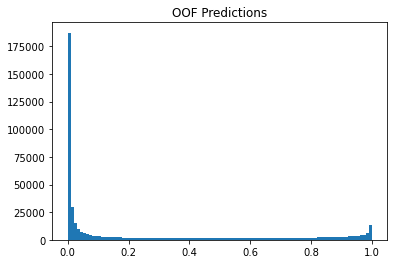

In [31]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

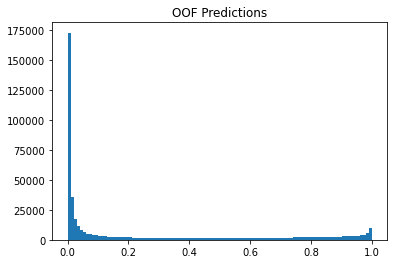

In [32]:
# PLOT OOF PREDICTIONS
plt.hist(y_prob, bins=100)
plt.title('OOF Predictions')
plt.show()

In [33]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof, y_oof
_ = gc.collect()

## Feature Importance counting

In [34]:
df = importances_xgb[0].copy()

for k in range(1, FOLDS):
    k_df = importances_xgb[k]
    df = df.merge(k_df, on='feature', how='left')

df['importance'] = df.iloc[:, 1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv('xgb_feature_importance_v{}.csv'.format(VER), index=False)

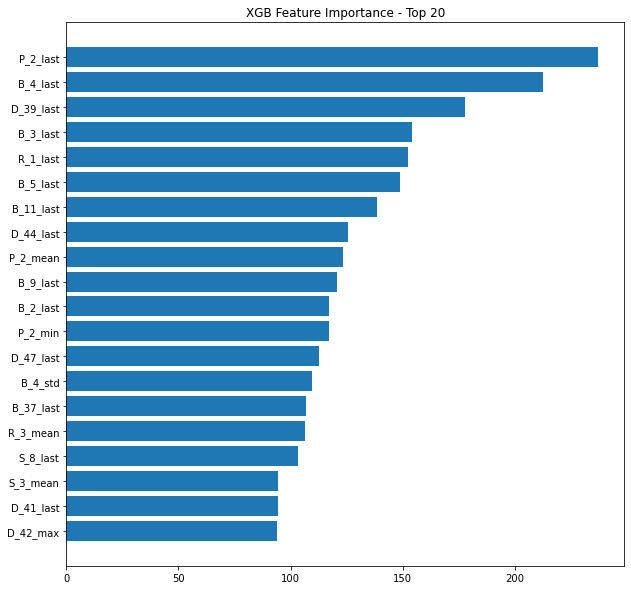

In [35]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

## Process and Feature Engineer Test Data

In [22]:
def get_rows(customers, test, NUM_PARTS=4, verbose = ''):
    chunk = len(customers) // NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    
    rows = []

    for k in range(NUM_PARTS):
        if k == NUM_PARTS - 1: 
            cc = customers[k * chunk:]
        else: 
            cc = customers[k * chunk: (k + 1) * chunk]
        
        s = test.loc[test[index_column].isin(cc)].shape[0]
        rows.append(s)
    
    if verbose != '':
        print(rows)
    
    return rows, chunk

In [23]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
print('Reading test data...')
test = pd.read_csv('test_data.csv', usecols=[index_column, time_column])

Reading test data...


In [24]:
NUM_PARTS = 8
customers = test[index_column].drop_duplicates().sort_index().values.flatten()
rows, num_cust = get_rows(customers, test, NUM_PARTS=NUM_PARTS, verbose='test')

We will process test data as 8 separate parts.
There will be 115577 customers in each part (except the last part).
Below are number of rows in each part:
[1420888, 1420308, 1420364, 1419480, 1421291, 1420809, 1421492, 1419130]


## Infer Test

In [25]:
test = pd.read_csv('test_data.csv', nrows=1)
T_COLS = test.columns

In [4]:
# INFER TEST DATA IN PARTS
skip_rows = 1
skip_cust = 0
xgb_test_preds = []
cb_test_preds = []

for k in range(NUM_PARTS):
    print('Predict for part =', k + 1)
    
    # READ CHUNK OF TEST CSV FILE
    skip = int(np.sum(rows[:k]) + 1) #the plus one is for skipping header
    test = read_file(path='test_data.csv', nrows=rows[k], skiprows=skip_rows, cols=T_COLS, scaler=scaler)
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape)
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]
    test = process_and_feature_engineer(test, cat_features, num_features, lbl, is_train=False)
    X_test = test[FEATURES]

    # INFER XGB MODELS ON TEST DATA
    dtest = xgb.DMatrix(data=X_test)
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    
    for f in range(1, FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    
    preds /= FOLDS
    xgb_test_preds.append(preds)
    
    # INFER CB MODELS ON TEST DATA
    model = CatBoostClassifier()
    model.load_model(f'CATBOOST_v{VER}_fold0.cbm')
    
    preds = np.zeros(test.shape[0])
    for f in range(0, FOLDS):
        model.load_model(f'CATBOOST_v{VER}_fold{f}.cbm')
        preds += model.predict_proba(X_test)[:, 1]
    
    preds /= FOLDS
    cb_test_preds.append(preds) 
    
    # CLEAN MEMORY
    del dtest, model, X_test
    _ = gc.collect()
    
    print()

In [ ]:
xgb_preds = np.concatenate(xgb_test_preds)
xgb_test = pd.DataFrame(data={'customer_ID': customers, 'prediction': xgb_preds})
xgb_test['customer_ID'] = xgb_test['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')
xgb_test = xgb_test.set_index('customer_ID')

In [ ]:
cb_preds = np.concatenate(cb_test_preds)
cb_test = pd.DataFrame(data={'customer_ID': customers, 'prediction': cb_preds})
cb_test['customer_ID'] = cb_test['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')
cb_test = cb_test.set_index('customer_ID')

## Create Submission CSV

In [ ]:
# WRITE SUBMISSION FILES
sub = pd.read_csv('sample_submission.csv')[[index_column]]
sub['customer_ID_hash'] = sub[index_column].apply(lambda x: int(x[-16:], 16)).astype('int64')
sub = sub.set_index('customer_ID_hash')

sub_xgb = sub.merge(xgb_test[['prediction']], left_index=True, right_index=True, how='left')
sub_xgb = sub_xgb.reset_index(drop=True)

sub_cb = sub.merge(cb_test[['prediction']], left_index=True, right_index=True, how='left')
sub_cb = sub_cb.reset_index(drop=True)

In [ ]:
# DISPLAY PREDICTIONS
sub_xgb.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub_xgb.shape)
sub_xgb.head()

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub_xgb.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

In [ ]:
# DISPLAY PREDICTIONS
sub_cb.to_csv(f'submission_cb_v{VER}.csv',index=False)
print('Submission file shape is', sub_cb.shape)
sub_cb.head()

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub_cb.prediction, bins=100)
plt.title('Test Predictions')
plt.show()